In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report, roc_curve

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


### Load the dataset

In [99]:
# Load the dataset
df = pd.read_csv('depression_data.csv') 

print(df.shape)
df.head(5)

(413768, 16)


,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes


# EDA 

### Checking for Nulls

In [100]:
df.isnull().sum()

Name                            0
Age                             0
Marital Status                  0
Education Level                 0
Number of Children              0
Smoking Status                  0
Physical Activity Level         0
Employment Status               0
Income                          0
Alcohol Consumption             0
Dietary Habits                  0
Sleep Patterns                  0
History of Mental Illness       0
History of Substance Abuse      0
Family History of Depression    0
Chronic Medical Conditions      0
dtype: int64

In [101]:
#df.isnull().mean()

### Would have dropped Nulls if limited or may have imputed (depednng on the analysis and model to be used). 
### If XGB then would have left Nulls as it is, if logisticRegression then would have imputed or deleted Nulls.

In [102]:
#df = df.dropna()
#df.shape

## Data Cleaning

### Renaming columns (removing spaces)

In [103]:
# Remove spaces from feature names
df.columns = df.columns.str.replace(' ', '_')
df.columns

Index(['Name', 'Age', 'Marital_Status', 'Education_Level',
       'Number_of_Children', 'Smoking_Status', 'Physical_Activity_Level',
       'Employment_Status', 'Income', 'Alcohol_Consumption', 'Dietary_Habits',
       'Sleep_Patterns', 'History_of_Mental_Illness',
       'History_of_Substance_Abuse', 'Family_History_of_Depression',
       'Chronic_Medical_Conditions'],
      dtype='object')

In [104]:
df = df.drop(columns=['Name']) # Dropping unwanted columns

In [105]:
target = 'History_of_Mental_Illness'

In [106]:
df.value_counts(target)

History_of_Mental_Illness
No     287943
Yes    125825
Name: count, dtype: int64

In [107]:
df[target] = df[target].map({'Yes': 1, 'No': 0}) # Converted Yes/No to 1/0

In [108]:
df.dtypes

Age                               int64
Marital_Status                   object
Education_Level                  object
Number_of_Children                int64
Smoking_Status                   object
Physical_Activity_Level          object
Employment_Status                object
Income                          float64
Alcohol_Consumption              object
Dietary_Habits                   object
Sleep_Patterns                   object
History_of_Mental_Illness         int64
History_of_Substance_Abuse       object
Family_History_of_Depression     object
Chronic_Medical_Conditions       object
dtype: object

In [109]:
# List of numeric and categorical features

numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_features.remove(target)  # Exclude the target variable

categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
#categorical_features.remove('Name')  # Exclude the  variable
#categorical_features.remove(target)  # Exclude the  variable

df.shape, len(categorical_features), len(numeric_features)

((413768, 15), 11, 3)

In [69]:
numeric_features

['Age', 'Number_of_Children', 'Income']

In [70]:
categorical_features

['Marital_Status',
 'Education_Level',
 'Smoking_Status',
 'Physical_Activity_Level',
 'Employment_Status',
 'Alcohol_Consumption',
 'Dietary_Habits',
 'Sleep_Patterns',
 'History_of_Substance_Abuse',
 'Family_History_of_Depression',
 'Chronic_Medical_Conditions']

### Summary statistics - No major outlier detected

In [71]:

summary = df[numeric_features].describe(include='all')
print("Summary Statistics:\n", summary)

Summary Statistics:
                  Age  Number_of_Children         Income
count  413768.000000       413768.000000  413768.000000
mean       49.000713            1.298972   50661.707971
std        18.158759            1.237054   40624.100565
min        18.000000            0.000000       0.410000
25%        33.000000            0.000000   21001.030000
50%        49.000000            1.000000   37520.135000
75%        65.000000            2.000000   76616.300000
max        80.000000            4.000000  209995.220000


### Checking for imbalanced dataset (2.3: 1)

In [72]:
df.value_counts(target)

History_of_Mental_Illness
0    287943
1    125825
Name: count, dtype: int64

## Looking at various statiscal tests and visualisations to understand data distribution to identify features that could have predictive power.

## Numerical Features

### Box plots for numeric features

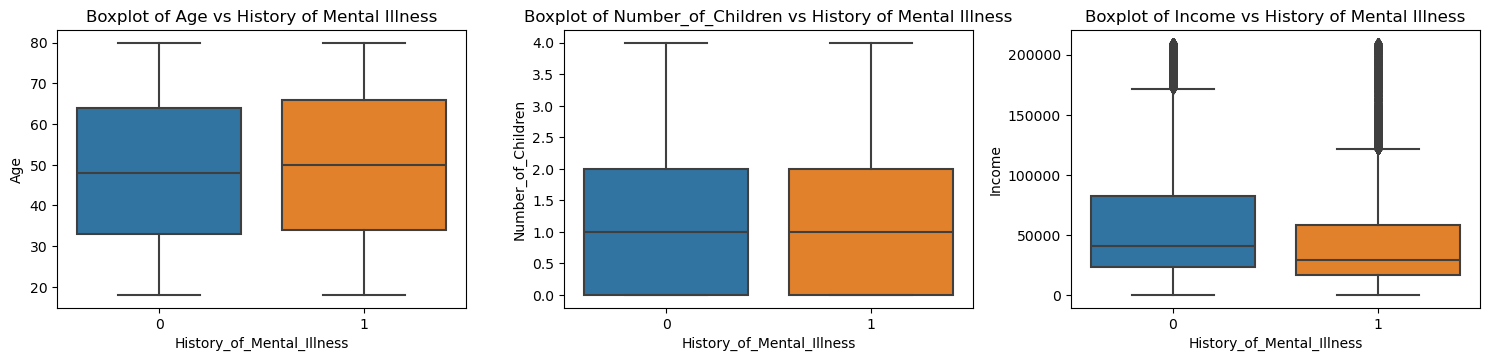

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features):
    plt.subplot(3, 3, i + 1)  # Adjust grid size as needed
    sns.boxplot(x=target, y=feature, data=df)
    plt.title(f'Boxplot of {feature} vs History of Mental Illness')

plt.tight_layout()
plt.show()


### Scatter plot matrix

/Users/abhi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/abhi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/abhi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


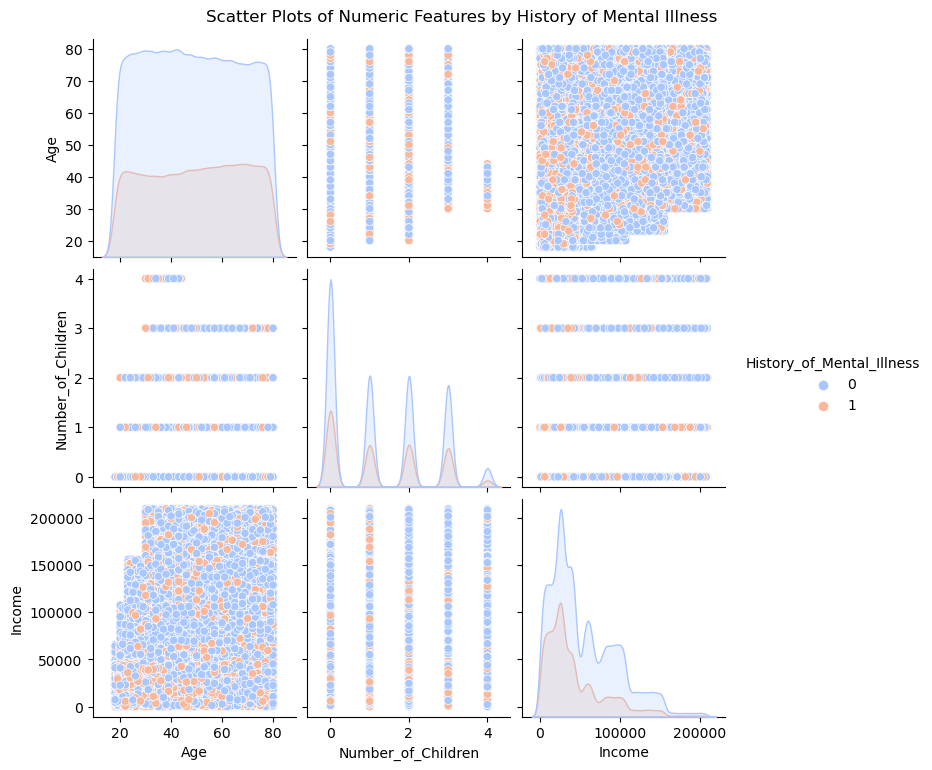

In [18]:

# Replace 'inf' and '-inf' with 'NaN' if any
df.replace([np.inf, -np.inf], np.nan, inplace=True)

sns.pairplot(df, vars=numeric_features, hue=target, palette='coolwarm')
plt.suptitle('Scatter Plots of Numeric Features by History of Mental Illness', y=1.02)
plt.show()

### Spearman correlation for monotonic relation

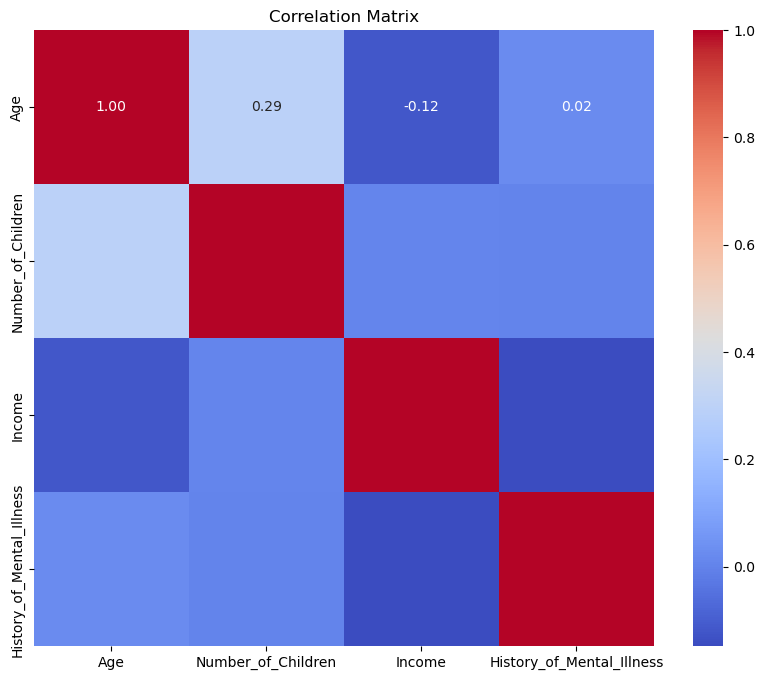

History_of_Mental_Illness    1.000000
Age                          0.024700
Number_of_Children           0.003696
Income                      -0.148133
Name: History_of_Mental_Illness, dtype: float64

In [20]:
# numeric
numeric_features_temp = numeric_features
numeric_features_temp.append(target)
correlation_matrix = df[numeric_features_temp].corr(method='spearman')
correlation_matrix

correlation_with_target = correlation_matrix[target].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

correlation_with_target

### Pearson correlation for linear relation

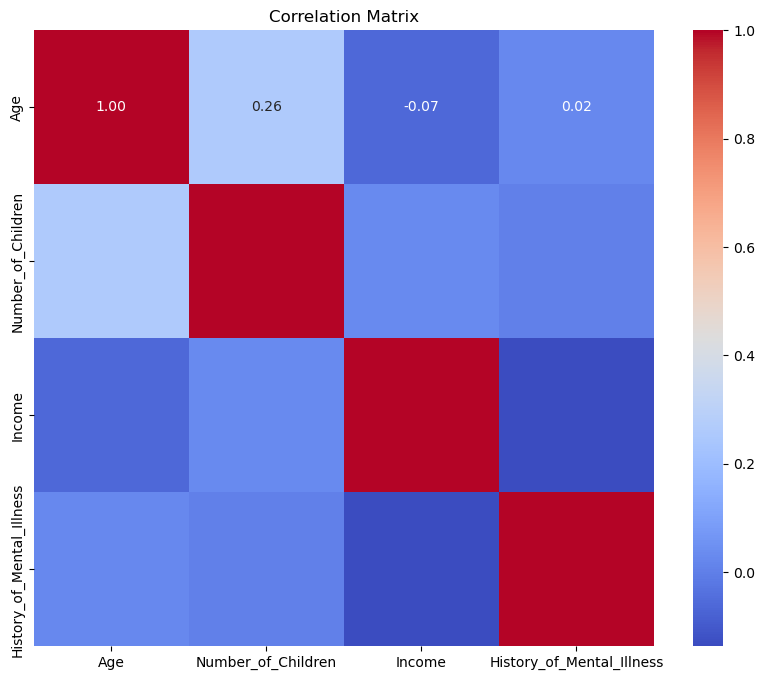

History_of_Mental_Illness    1.000000
Age                          0.024683
Number_of_Children           0.002713
Income                      -0.136805
Name: History_of_Mental_Illness, dtype: float64

In [73]:
# numeric
numeric_features_temp = numeric_features
numeric_features_temp.append(target)
correlation_matrix = df[numeric_features_temp].corr(method='pearson')
correlation_matrix

correlation_with_target = correlation_matrix[target].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

correlation_with_target

### Income looks like a good candidate, Age has weak (linear or monotinic) correlation and can be explored


## Categorical Features

In [21]:
from scipy.stats import chi2_contingency

# Using Chi-Square test for possible associations

for cat_col in categorical_features:
    contingency_table = pd.crosstab(df[cat_col], df[target])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    print(f'Feature: {cat_col}')
    print(f'Chi2 Statistic: {chi2:.4f}, P-value: {p_value:.4f}')
    if p_value < 0.05:
        print(f'{cat_col} is significantly associated with the target variable.\n')
    else:
        print(f'{cat_col} is not significantly associated with the target variable.\n')


Feature: Marital_Status
Chi2 Statistic: 64.8468, P-value: 0.0000
Marital_Status is significantly associated with the target variable.

Feature: Education_Level
Chi2 Statistic: 1400.3934, P-value: 0.0000
Education_Level is significantly associated with the target variable.

Feature: Smoking_Status
Chi2 Statistic: 11.4441, P-value: 0.0033
Smoking_Status is significantly associated with the target variable.

Feature: Physical_Activity_Level
Chi2 Statistic: 30.3591, P-value: 0.0000
Physical_Activity_Level is significantly associated with the target variable.

Feature: Employment_Status
Chi2 Statistic: 8197.9710, P-value: 0.0000
Employment_Status is significantly associated with the target variable.

Feature: Alcohol_Consumption
Chi2 Statistic: 76.2922, P-value: 0.0000
Alcohol_Consumption is significantly associated with the target variable.

Feature: Dietary_Habits
Chi2 Statistic: 362.3016, P-value: 0.0000
Dietary_Habits is significantly associated with the target variable.

Feature: Sleep

### Employment_Status, Education_level, and to some extent sleep_patterns seems to be good candidate

In [22]:
# Uisng Cramér’s V to look at strength of association

import numpy as np
import scipy.stats as stats

def cramers_v(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# For each categorical feature
for col in categorical_features:
    confusion_matrix = pd.crosstab(df[col], df[target])
    print(f"Cramér's V for {col}: {cramers_v(confusion_matrix)}")


Cramér's V for Marital_Status: History_of_Mental_Illness
0    0.015007
1    0.022702
dtype: float64
Cramér's V for Education_Level: History_of_Mental_Illness
0    0.069738
1    0.105497
dtype: float64
Cramér's V for Smoking_Status: History_of_Mental_Illness
0    0.006304
1    0.009537
dtype: float64
Cramér's V for Physical_Activity_Level: History_of_Mental_Illness
0    0.010268
1    0.015533
dtype: float64
Cramér's V for Employment_Status: History_of_Mental_Illness
0    0.168733
1    0.255252
dtype: float64
Cramér's V for Alcohol_Consumption: History_of_Mental_Illness
0    0.016277
1    0.024624
dtype: float64
Cramér's V for Dietary_Habits: History_of_Mental_Illness
0    0.035472
1    0.053660
dtype: float64
Cramér's V for Sleep_Patterns: History_of_Mental_Illness
0    0.045330
1    0.068574
dtype: float64
Cramér's V for History_of_Substance_Abuse: History_of_Mental_Illness
0    0.002070
1    0.003132
dtype: float64
Cramér's V for Family_History_of_Depression: History_of_Mental_Illness

### Employment_Status, Education_level looks like good candidates

In [110]:
import pandas as pd
import numpy as np

# Function to calculate WoE and IV for a single variable
def calc_woe_iv(data, feature, target):
    # Create a dataframe with counts of target variable for each unique value in the feature
    feature_data = data.groupby(feature)[target].agg(['count', 'sum'])
    feature_data.columns = ['Total', 'Good']
    feature_data['Bad'] = feature_data['Total'] - feature_data['Good']
    
    # Calculate distribution of Good and Bad for each feature level
    feature_data['Distr_Good'] = feature_data['Good'] / feature_data['Good'].sum()
    feature_data['Distr_Bad'] = feature_data['Bad'] / feature_data['Bad'].sum()
    
    # Replace zero values to avoid division by zero or taking log(0)
    feature_data.replace({'Distr_Bad': {0: 1e-10}, 'Distr_Good': {0: 1e-10}}, inplace=True)
    
    # Calculate WoE and IV
    feature_data['WoE'] = np.log(feature_data['Distr_Good'] / feature_data['Distr_Bad'])
    feature_data['IV'] = (feature_data['Distr_Good'] - feature_data['Distr_Bad']) * feature_data['WoE']
    
    # Summing up IV
    iv = feature_data['IV'].sum()
    
    return feature_data[['WoE']], iv

# Function to calculate WoE and IV for all features
def woe_iv_analysis(df, target, exclude_features=[]):
    iv_dict = {}
    woe_dict = {}
    
    for feature in df.columns:
        if feature not in exclude_features + [target]:
            if df[feature].dtype == 'object' or len(df[feature].unique()) < 10:
                # Treat categorical and discrete features
                woe_df, iv = calc_woe_iv(df, feature, target)
            else:
                # Bin numeric features into 10 equal-sized bins for WoE calculation
                df[feature + '_bin'] = pd.qcut(df[feature], q=10, duplicates='drop')
                woe_df, iv = calc_woe_iv(df, feature + '_bin', target)
            
            # Store the results
            iv_dict[feature] = iv
            woe_dict[feature] = woe_df
    
    return woe_dict, iv_dict



# Perform WoE and IV analysis, excluding 'Name' from the analysis
woe, iv = woe_iv_analysis(df, target=target)

# Display results
'''
print("WoE Values:")
for feature, woe_df in woe.items():
    print(f"\nFeature: {feature}")
    print(woe_df)
'''

print("\nIV Values:")
for feature, iv_value in iv.items():
    print(f"Feature: {feature}, IV: {iv_value}")


/var/folders/x4/9h78zrw10712t4w2llqsgzhc0000gn/T/ipykernel_10102/3975594007.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feature_data = data.groupby(feature)[target].agg(['count', 'sum'])
/var/folders/x4/9h78zrw10712t4w2llqsgzhc0000gn/T/ipykernel_10102/3975594007.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feature_data = data.groupby(feature)[target].agg(['count', 'sum'])



IV Values:
Feature: Age, IV: 0.004782983245566276
Feature: Marital_Status, IV: 0.000740526337218787
Feature: Education_Level, IV: 0.015994062584914835
Feature: Number_of_Children, IV: 0.0005197262709328247
Feature: Smoking_Status, IV: 0.00013101053246274675
Feature: Physical_Activity_Level, IV: 0.0003472763144644744
Feature: Employment_Status, IV: 0.09158548801910088
Feature: Income, IV: 0.11081120209914519
Feature: Alcohol_Consumption, IV: 0.000865934331620041
Feature: Dietary_Habits, IV: 0.0042189912620418405
Feature: Sleep_Patterns, IV: 0.006820241493353982
Feature: History_of_Substance_Abuse, IV: 1.4178301643340086e-05
Feature: Family_History_of_Depression, IV: 0.00011263004969340947
Feature: Chronic_Medical_Conditions, IV: 0.00017195227524633263


#### Data Preparation for the model

In [128]:

#X = df.head(100000).drop(columns=[target])
#y = df.head(100000)[target]

#X = df.drop(columns=[target])

X = df[selected_features]
y = df[target]

X.shape, y.shape

((413768, 4), (413768,))

### Encoding categorical variables

In [129]:

X = pd.get_dummies(X, drop_first=True, dtype=int)
X = X.astype(int)
X.shape

(413768, 7)

In [130]:
X.head(3)

,Income,Age,Employment_Status_Unemployed,Education_Level_Bachelor's Degree,Education_Level_High School,Education_Level_Master's Degree,Education_Level_PhD
0,26265,31,1,1,0,0,0
1,42710,55,0,0,1,0,0
2,125332,78,0,0,0,1,0


### Statified Train-test split

In [131]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((289637, 7), (289637,), (124131, 7), (124131,))

In [132]:
# Remove spaces from feature names
X_train.columns = X_train.columns.str.replace(' ', '_')
X_train.columns

Index(['Income', 'Age', 'Employment_Status_Unemployed',
       'Education_Level_Bachelor's_Degree', 'Education_Level_High_School',
       'Education_Level_Master's_Degree', 'Education_Level_PhD'],
      dtype='object')

In [133]:
X_train.head(2)

,Income,Age,Employment_Status_Unemployed,Education_Level_Bachelor's_Degree,Education_Level_High_School,Education_Level_Master's_Degree,Education_Level_PhD
307289,14051,67,1,0,0,1,0
12942,11378,49,1,1,0,0,0


In [134]:
y_train.head(2)

307289    0
12942     1
Name: History_of_Mental_Illness, dtype: int64

In [37]:
X_train.columns 

Index(['Income', 'Age', 'Employment_Status_Unemployed',
       'Education_Level_Bachelor's Degree', 'Education_Level_High School',
       'Education_Level_Master's Degree', 'Education_Level_PhD'],
      dtype='object')

### Because the dataset is imbalanced so oversampling the minority class

In [39]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [40]:
X_resampled.head(3)

,Income,Age,Employment_Status_Unemployed,Education_Level_Bachelor's Degree,Education_Level_High School,Education_Level_Master's Degree,Education_Level_PhD
0,14051,67,1,0,0,1,0
1,11378,49,1,1,0,0,0
2,4608,18,1,0,1,0,0


### I ran an XGB classifer model to get feature importance to identify top features to be used in the final model

In [ ]:
'''
xgb = XGBClassifier() #eval_metric='logloss', use_label_encoder=False enable_categorical=True

#xgb.fit(X_train, y_train)  
xgb.fit(X_resampled, y_resampled)  

y_pred_proba = xgb.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
auc_score
'''

In [ ]:

'''
y_pred = xgb.predict(X_test)
print("\nClassification Report for Best Model:\n", classification_report(y_test, y_pred, zero_division=0))
'''

In [ ]:
# Get feature importances

'''
importance = xgb.feature_importances_
features = X_resampled.columns  
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importance})
print(feature_importance.sort_values(by='Importance', ascending=False))
'''

### Final list of selected feature to be used for Modeling

In [114]:
selected_features = ['Income', 'Age', 'Employment_Status', 'Education_Level']

### Choosing a range of Models (LG for linear and XGB for non linear) and hyperparameters to identify the best model

In [41]:

models = {
    
    'XGBoost': (XGBClassifier(eval_metric=['logloss', 'auc']), { #, scale_pos_weight=2.3
        'n_estimators': [20, 50, 100],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [None, 10, 20]
    }),
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }),
    'LightGBM': (LGBMClassifier(), {
       'n_estimators': [50, 70, 100],
       'learning_rate': [0.01, 0.1, 0.2],
       'max_depth': [None, 10, 20]
    }),
    
    'Logistic Regression': (LogisticRegression(), { 
        'max_iter': [50, 100, 200],
        'C': [0.1, 1.0, 10],
        'solver': ['liblinear', 'saga']
    })
    }


In [42]:
for model_name, (model, params) in models.items():
    print(model_name)
    print("-----")
    print((model, params) )

XGBoost
-----
(XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['logloss', 'auc'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...), {'n_estimators': [20, 50, 100], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [None, 10, 20]})
Random Forest
-----
(RandomForestClassifier(), {'n_estimators': [50, 100], 'max_depth': [None, 10, 20], 'min_sample

### Hyperparameter tuning and model evaluation

In [43]:

results = {}

for model_name, (model, params) in models.items():
    grid_search = GridSearchCV(model, params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0) # cv=5,
    grid_search.fit(X_resampled, y_resampled) #(X_train, y_train) #

    # Best model
    best_model = grid_search.best_estimator_
    
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    results[model_name] = {
            'Best Params': grid_search.best_params_,
            'AUC-ROC': auc_score
        }


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 201560, number of negative: 201560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 329
[LightGBM] [Info] Number of data points in the train set: 403120, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/abhi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/abhi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/abhi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/abhi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/abhi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/abhi/anaconda3/lib/python3.11/site-packages/sklearn/linear_mode

In [44]:
results

{'XGBoost': {'Best Params': {'learning_rate': 0.1,
   'max_depth': 10,
   'n_estimators': 100},
  'AUC-ROC': 0.5609651165265063},
 'Random Forest': {'Best Params': {'max_depth': 20,
   'min_samples_split': 2,
   'n_estimators': 100},
  'AUC-ROC': 0.5494463361024947},
 'LightGBM': {'Best Params': {'learning_rate': 0.2,
   'max_depth': 10,
   'n_estimators': 100},
  'AUC-ROC': 0.5679578459200476},
 'Logistic Regression': {'Best Params': {'C': 10,
   'max_iter': 50,
   'solver': 'saga'},
  'AUC-ROC': 0.590675788533411}}

In [45]:
results_df = pd.DataFrame(results).T
#print("\nModel Evaluation Results:\n", results_df)
results_df

,Best Params,AUC-ROC
XGBoost,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.560965
Random Forest,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...",0.549446
LightGBM,"{'learning_rate': 0.2, 'max_depth': 10, 'n_est...",0.567958
Logistic Regression,"{'C': 10, 'max_iter': 50, 'solver': 'saga'}",0.590676


### Selecting the best model

In [46]:
best_model_name = results_df['AUC-ROC'].idxmax()
best_model = models[best_model_name][0].set_params(**results[best_model_name]['Best Params'])
best_model_name

'Logistic Regression'

In [47]:
best_model

LogisticRegression(C=10, max_iter=50, solver='saga')

### Printing Precison-Recall Curve

/Users/abhi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


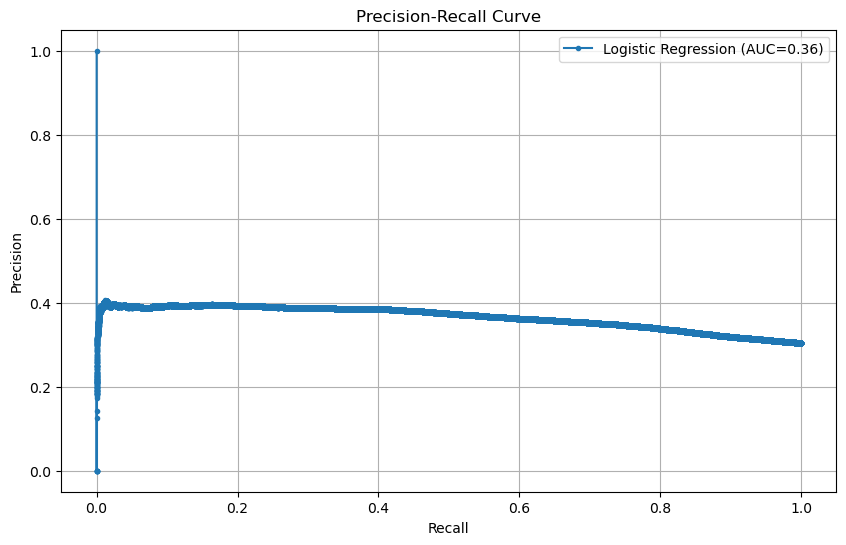

In [48]:
# Display results

results_df = pd.DataFrame(results).T
#print("\nModel Evaluation Results:\n", results_df)

# Precision-Recall Curve for the best model
best_model_name = results_df['AUC-ROC'].idxmax()
best_model = models[best_model_name][0].set_params(**results[best_model_name]['Best Params'])

best_model.fit(X_resampled, y_resampled) #(X_train, y_train)#

y_pred_proba = best_model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label=f'{best_model_name} (AUC={pr_auc:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()


### Printing Classification Report for the best model

In [49]:

y_pred = best_model.predict(X_test)
print("\nClassification Report for Best Model:\n", classification_report(y_test, y_pred, zero_division=0))


Classification Report for Best Model:
               precision    recall  f1-score   support

           0       0.72      0.77      0.75     86383
           1       0.39      0.33      0.36     37748

    accuracy                           0.64    124131
   macro avg       0.56      0.55      0.55    124131
weighted avg       0.62      0.64      0.63    124131



### Printing AUC-ROC Curve

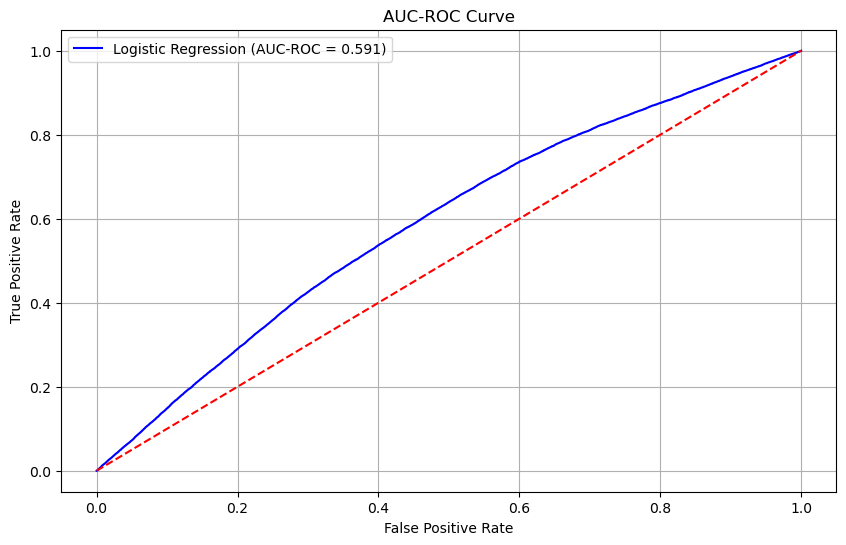

In [50]:
# Plot the AUC-ROC Curve

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'{best_model_name} (AUC-ROC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('AUC-ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

### Printing Feature Importance

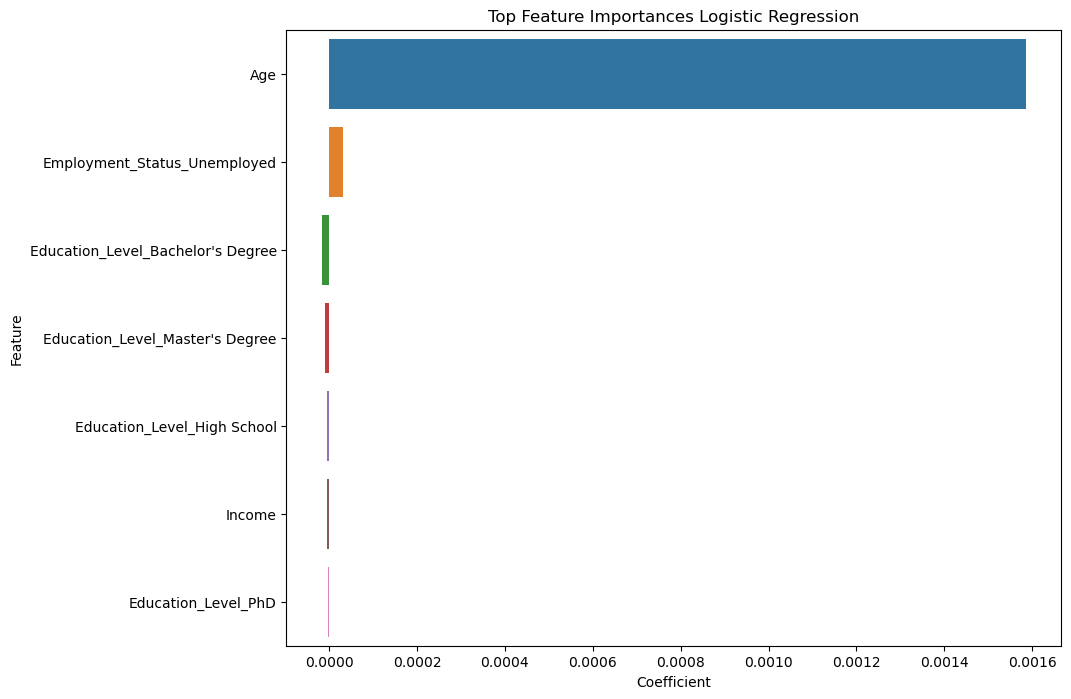

In [53]:
if best_model_name == 'Logistic Regression':
    feature_importance_df = pd.DataFrame({
    'Feature': X_resampled.columns,
    'Coefficient': best_model.coef_[0],
    'Coefficient_abs': abs(best_model.coef_[0])
    })

    feature_importance_df = feature_importance_df.sort_values(by='Coefficient_abs', ascending=False)
    
    # Plotting feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance_df)  
    plt.title(f'Top Feature Importances {best_model_name}')
    plt.show()
    
    #print(coefficients)
else:
    importance = best_model.feature_importances_
    
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    # Plotting feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)  
    plt.title(f'Top Feature Importances {best_model_name}')
    plt.show()


### Could also do Shap and PDP from business point of view to understand which features are most critical and how they could be used in business strategy

## As a base test I ran the model with more features (all), and the results were same as we get from the 4 selected feature.

### For post model deployment managament, I would code for PSI (& CSI) and model metrics to track over time, and flag when there is data or model drift over the suggested threshold.